## Imports

In [1]:
import sys
import nltk
import numpy as np
import pandas as pd
import pickle
# from helpers import *
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import metrics
import os
from matplotlib import pyplot as plt

from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
sys.path.append(".")
sys.path.append("..")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Set params

In [2]:
text_column = "body"
column_to_predict = "category"

use_grid_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming

## Load dataset

In [3]:
data = pd.read_csv('../data/all_tickets.csv')

In [4]:
data.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             47837 non-null  object
 1   body              48549 non-null  object
 2   ticket_type       48549 non-null  int64 
 3   category          48549 non-null  int64 
 4   sub_category1     48549 non-null  int64 
 5   sub_category2     48549 non-null  int64 
 6   business_service  48549 non-null  int64 
 7   urgency           48549 non-null  int64 
 8   impact            48549 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 3.3+ MB


## Prepare data and labels and split them to train and test sets

In [6]:
text_list = data['body'].tolist()

In [7]:
text_list[0]

'hi since recruiter lead permission approve requisitions makes please make thanks recruiter'

In [8]:
def clean(sentence):
    
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer() 
  
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]  

    stemmed_sentence = [ps.stem(w) for w in filtered_sentence]

    return ' '.join(stemmed_sentence)

In [9]:
text_list = [clean(sentence) for sentence in text_list]

In [10]:
text_list[0]

'hi sinc recruit lead permiss approv requisit make pleas make thank recruit'

In [11]:
labels_list = data['category'].tolist()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(text_list, labels_list, test_size=0.1, random_state=0)

## train classifier with default parameters or use GridSearchCV to search for best set of parameters

In [13]:
print("Training SGD classifier")

text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ])

if use_grid_search:
    # Grid Search
    # Here, we are creating a list of parameters for which we would like to do performance tuning.
    # All the parameters name start with the classifier name (remember the arbitrary name we gave).
    # E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

    # NB parameters
    parameters = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__use_idf': (True, False),
        'clf__alpha': (1, 1e-1, 1e-2, 1e-3)
    }

    # Next, we create an instance of the grid search by passing the classifier, parameters
    # and n_jobs=-1 which tells to use multiple cores from user machine.
    text_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
    text_clf = text_clf.fit(X_train, y_train)
    
    # To see the best mean score and the params, run the following code
    text_clf.best_score_
    text_clf.best_params_
    
    print(text_clf.best_params_)
else:
    text_clf = text_clf.fit(X_train, y_train)

Training SGD classifier


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


## Evaluate the model

In [14]:
# Score and evaluate model on test data using model WITH hyperparameter tuning
if use_grid_search:
    predicted = text_clf.predict(X_test)
    prediction_acc = np.mean(predicted == y_test)
    print("Mean with GridSearch: " + str(prediction_acc))
else:
    print("Evaluating model")
    # Score and evaluate model on test data using model without hyperparameter tuning
    predicted = text_clf.predict(X_test)
    prediction_acc = np.mean(predicted == y_test)
    print("Mean without GridSearch: " + str(prediction_acc))

Mean with GridSearch: 0.8494335736354274


## Ploting confusion matrix

In [15]:
import itertools

# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

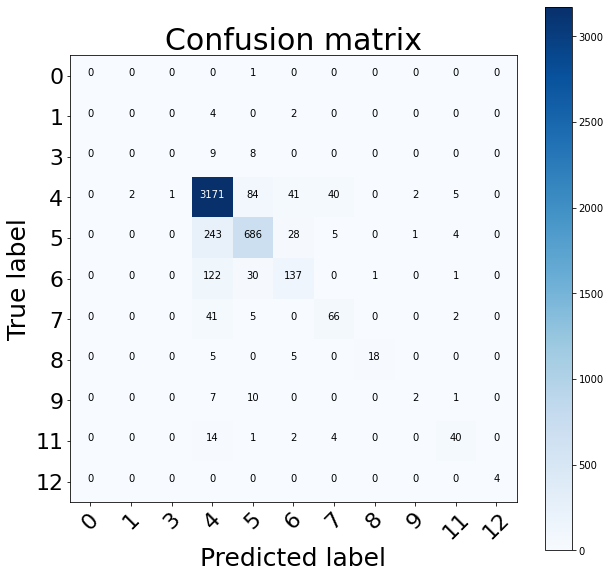

In [16]:
cnf_matrix = confusion_matrix(y_test, predicted)
fig = plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_test), title="Confusion matrix")
plt.show()
fig.savefig('../plots/nb_cm.png')
plt.close(fig)

## Printing classification report

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


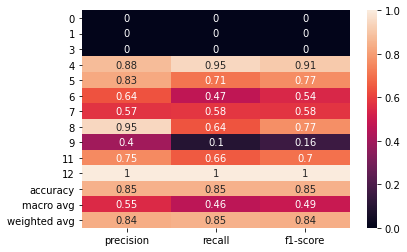

In [17]:
report = classification_report(y_test, predicted, target_names=np.unique(y_test), output_dict=True)

sns_plot = sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
fig = sns_plot.get_figure()
fig.savefig("../plots/nb_report.png") 

## Salvataggio del modello

In [18]:
with open('../models/nb.pickle', 'wb') as handle:
    pickle.dump(text_clf, handle, protocol=pickle.HIGHEST_PROTOCOL)